In [1]:
!pip install fastdtw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512408 sha256=810706b788e63ef0a0e834262d7c77ee36a708e05372cd1ccde44bbbf4304513
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab74c3acf4848bc25d513c736bb93910277e1528ef4
Successfully built fastdtw


In [7]:
import numpy as np
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
import matplotlib.pyplot as plt
import pandas as pd

In [32]:
class dongha_mingi_model:

    def __init__(self, last, last_gdp, last_con):
        self.last = last
        self.last_gdp = last_gdp
        self.last_con = last_con

    def fit(self, alpha, beta, threshold):
        last = self.last[['Date', 'Close']].copy()
        last_arr = last.iloc[:, 1].to_numpy().reshape(-1, 1)
        last_gdp_arr = self.last_gdp.reshape(-1, 1).copy()
        last_con_arr = self.last_con.reshape(-1, 1).copy()

        last_max = np.max(last_arr)
        last_min = np.min(last_arr)
        last_gdp_max = np.max(last_gdp_arr)
        last_gdp_min = np.min(last_gdp_arr)
        last_con_max = np.max(last_con_arr)
        last_con_min = np.min(last_con_arr)

        for i in range(len(last_arr)):
            last_arr[i] = (last_arr[i] - last_min) / (last_max - last_min)

        for i in range(len(last_gdp_arr)):
            last_gdp_arr[i] = (last_gdp_arr[i] - last_gdp_min) / (last_gdp_max - last_gdp_min)

        for i in range(len(last_con_arr)):
            last_con_arr[i] = (last_con_arr[i] - last_con_min) / (last_con_max - last_con_min)

        gdp_distance, gdp_path = fastdtw(last_gdp_arr, last_arr, dist=euclidean)
        con_distance, con_path = fastdtw(last_con_arr, last_arr, dist=euclidean)

        last_ratio = 0
        gdp_ratio = gdp_distance / (gdp_distance + con_distance)
        con_ratio = con_distance / (gdp_distance + con_distance)

        last_weight = 1 - last_ratio
        gdp_weight = 1 - gdp_ratio
        con_weight = 1 - con_ratio

        weight_list = [last_weight, gdp_weight, con_weight]

        for i in range(len(weight_list)):
            if weight_list[i] < threshold:
                weight_list[i] = 0

        result = []

        for i in range(len(last_arr)):
            result.append(last_arr[i] * last_weight + last_gdp_arr[i] * gdp_weight + last_con_arr[i] * con_weight)

        def double_exponential_smoothing(data, alpha, beta):
            level = data[0]
            trend = 0
            forecast = [data[0]]

            for t in range(1, len(data)) :
              prev_level = level
              prev_trend = trend

              level = alpha * data[t] + (1 - alpha) * (prev_level + prev_trend)
              trend = beta * (level - prev_level) + (1 - beta) * prev_trend

              forecast_t = level + trend
              forecast.append(forecast_t)

            return forecast

        forecast_th = double_exponential_smoothing(result, alpha, beta)

        forecast_last_th = []

        for i in range(len(forecast_th)):
            forecast_last_th.append(forecast_th[i][0])

        plt.figure(figsize=(8, 6))
        plt.plot(np.arange(len(forecast_last_th)), forecast_last_th)
        plt.title('Forecast with threshold')
        plt.show()


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [36]:
last = pd.read_csv("/content/drive/MyDrive/캡스톤디자인/KOSPI2022.csv")
last_gdp =np.array([512012.9, 512012.9, 512012.9, 544239.8, 544239.8, 544239.8, 548892.5, 548892.5, 548892.5, 556628.7, 556628.7, 556628.7])
last_con = pd.read_csv("/content/drive/MyDrive/캡스톤디자인/2022소비자물가지수.csv")
last_con = last_con.iloc[0, :]
last_con = last_con[1:].to_numpy()

In [37]:
model = dongha_mingi_model(last, last_gdp, last_con)

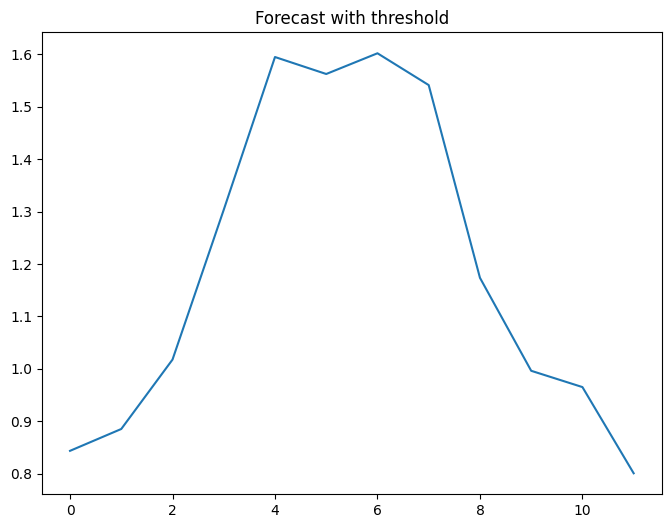

In [42]:
model.fit(0.3, 0.7, 0.5)